In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## Paso 2: Cargando los datos

In [2]:
amazon = pd.read_csv('amazon.tsv', sep='\t')
amazon.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_date
0,US,12076615,RQ58W7SMO911M,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,4,2,3,N,N,this book was a great learning novel!,2005-10-14
1,US,12703090,RF6IUKMGL8SF,0811828964,56191234,The Bad Girl's Guide to Getting What You Want,Books,3,5,5,N,N,Fun Fluff,2005-10-14
2,US,12257412,R1DOSHH6AI622S,1844161560,253182049,"Eisenhorn (A Warhammer 40,000 Omnibus)",Books,4,1,22,N,N,this isn't a review,2005-10-14
3,US,50732546,RATOTLA3OF70O,0373836635,348672532,Colby Conspiracy (Colby Agency),Books,5,2,2,N,N,fine author on her A-game,2005-10-14
4,US,51964897,R1TNWRKIVHVYOV,0262181533,598678717,The Psychology of Proof: Deductive Reasoning i...,Books,4,0,2,N,N,Execellent cursor examination,2005-10-14


## Paso 3: Limpieza y Exploración de los Datos

Hay 140752 títulos únicos en el dataset.

El top 10 de títulos con más repeticiones es: product_title
Harry Potter and the Half-Blood Prince (Book 6)                                                        2202
Natural Cures "They" Don't Want You to Know about                                                       916
The FairTax Book                                                                                        765
100 People Who Are Screwing Up America (And Al Franken Is #37)                                          633
The Historian                                                                                           598
Freakonomics: A Rogue Economist Explores the Hidden Side of Everything                                  497
The Kite Runner                                                                                         444
Eldest (Inheritance, Book 2)                                                                            366
The Truth About Hillary: What She 

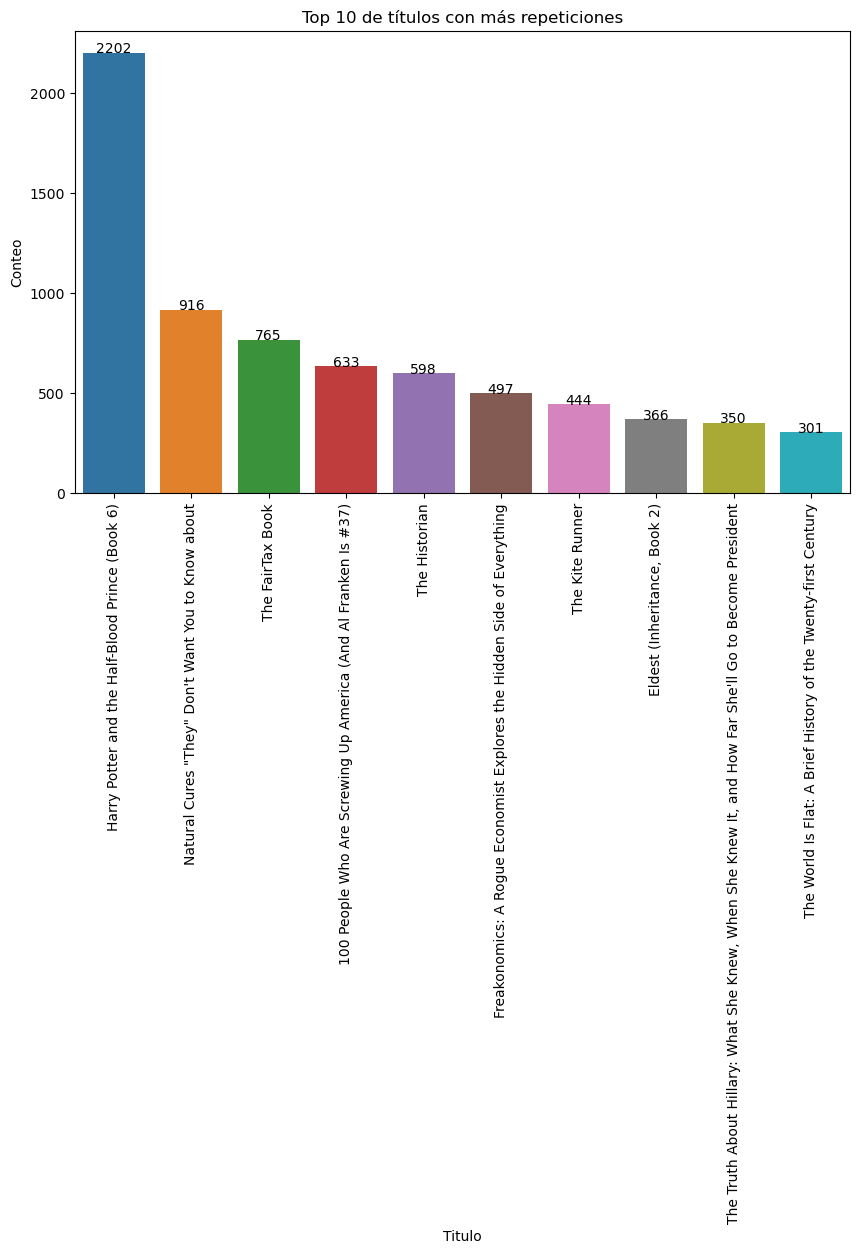

In [3]:
# Eliminar duplicados
amazon = amazon.drop_duplicates()

# Eliminar filas con valores nulos
amazon = amazon.dropna()

# Pasar la fecha al tipo de dato correcto
amazon['review_date'] = pd.to_datetime(amazon['review_date'])

# Eliminar columnas que no aportan información
amazon = amazon.drop(columns=['marketplace', 'product_category'])

# Tratamiento de valores atípicos
def detectar_y_tratar_valores_atipicos(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Ajustar valores atípicos
    df[col] = np.where(df[col] < limite_inferior, limite_inferior, df[col])
    df[col] = np.where(df[col] > limite_superior, limite_superior, df[col])

    return df

amazon = detectar_y_tratar_valores_atipicos(amazon, 'helpful_votes')
amazon = detectar_y_tratar_valores_atipicos(amazon, 'total_votes')
amazon = detectar_y_tratar_valores_atipicos(amazon, 'star_rating')

amazon.describe()

# Agrupar por titulo y contar el número de repeticiones
titulos = amazon.groupby('product_title')
titulos = titulos.size().sort_values(ascending=False)
print(f"Hay {len(titulos)} títulos únicos en el dataset.")
print()
print(f"El top 10 de títulos con más repeticiones es: {titulos.head(10)}")

# Utilizaremos barplot para visualizar esta información
conteo_titulos_df = pd.DataFrame([titulos]).T.reset_index()
conteo_titulos_df.columns = ['Titulo', 'Conteo']
conteo_titulos_df = conteo_titulos_df.sort_values(by='Conteo', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Titulo', y='Conteo', data=conteo_titulos_df.head(10))
plt.title('Top 10 de títulos con más repeticiones')
for indice, fila in conteo_titulos_df.head(10).iterrows():
    plt.text(indice, fila['Conteo'], fila['Conteo'], color='black', ha="center")
plt.xticks(rotation=90)
plt.show()

In [4]:
# Numeros de estrellas 
estrellas = amazon.groupby('star_rating')
estrellas = estrellas.size().sort_values(ascending=False)
print(f"Hay {len(estrellas)} estrellas únicas en el dataset.")
print()
print(f"El top 4 de estrellas con más repeticiones es: {estrellas.head(4)}")

print()

# Compra verificada
verificado = amazon.groupby('verified_purchase')
verificado = verificado.size().sort_values(ascending=False)
print(f"Hay {len(verificado)} valores únicos en la columna verified_purchase.")
print()
print(f"El top 2 de valores con más repeticiones en la columna verified_purchase es: {verificado.head(2)}")



Hay 4 estrellas únicas en el dataset.

El top 4 de estrellas con más repeticiones es: star_rating
5.0    175875
4.0     58647
2.5     39362
3.0     26060
dtype: int64

Hay 2 valores únicos en la columna verified_purchase.

El top 2 de valores con más repeticiones en la columna verified_purchase es: verified_purchase
N    261926
Y     38018
dtype: int64


## Paso 4: Transformando los datos

In [5]:
estrellas = amazon['star_rating'].unique()

for estrella in estrellas: 
    amazon[estrella] = amazon['star_rating'].transform(lambda x: 1 if x == estrella else 0)

amazon[estrellas].head()



,4.0,3.0,5.0,2.5
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0


In [6]:
# Crear columnas para cada valor de la columna verified_purchase
compra_verificada = pd.get_dummies(amazon['verified_purchase'])
compra_verificada.head()

# Transformar la columna 'Y' a 1 si es una compra verificada y 0 si no lo es
compra_verificada['Y'] = np.where(amazon['verified_purchase'] == 'Y', 1, 0)
compra_verificada['N'] = np.where(amazon['verified_purchase'] == 'N', 1, 0)

In [7]:
amazon_caracteristicas = pd.concat([amazon[estrellas], compra_verificada], axis=1)
amazon_caracteristicas.head()

,4.0,3.0,5.0,2.5,N,Y
0,1,0,0,0,1,0
1,0,1,0,0,1,0
2,1,0,0,0,1,0
3,0,0,1,0,1,0
4,1,0,0,0,1,0


# Paso 5: Construyendo un sistema de recomendación utilizando similitud Coseno

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

sim_coseno = cosine_similarity(amazon_caracteristicas, amazon_caracteristicas)

: 